## Load Parameters & Other Essentials

### Load the Training Dataset

In [455]:
dataset_file = './trainingdata_stepwise_turkish_3_articulators.tsv'

### Load the packages and functions

In [456]:
from dev import *
import pandas as pd
import numpy as np
import torch
import statsmodels.api as sm

data_stepwise = Dataset(dataset_file)

./trainingdata_stepwise_turkish_3_articulators.tsv


/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most r

## Evaluation Data Preparation

### Define the articulators to be used by different models

In [457]:
rounding = ["la_output", "tb_output"]
round_and_front = ["la_output", "tb_output", "tc_output"]
front = ["tb_output", "tc_output"]
analyses = [rounding, round_and_front, front]

def get_analysis_name(ls: list) -> str:
    if ls == rounding:
        return 'rounding'
    if ls == round_and_front:
        return 'round_and_front'
    if ls == front:
        return 'fronting'

# load dataframe
data = pd.read_csv(dataset_file, sep='\t')
data = data[data['syllables']==2]

### Create several models for each analysis and construct a dataframe

In [458]:
# define functions to be used when building the dataframe

# helper function to get decoder outputs
def get_decoder(input: torch.Tensor, target: torch.Tensor, model) -> np.ndarray:
    with torch.no_grad():
        predicted, attn_map_seq = model(input, target)
        # don't reduce since we want to know the loss at various time steps
        loss = torch.nn.functional.mse_loss(predicted.float(), target.float(), reduction='none')
        loss_art_avg = torch.mean(torch.sqrt(loss), 1)
    return loss_art_avg.numpy(), attn_map_seq.numpy()[:,0] # attention paid to the first letter

# helper functions to get correct inputs
def get_trial(training_data, word, model):
    trial = training_data.make_trial(word)
    target_values = []
    target_dict = {'la_output':1, 'tb_output':2, 'tc_output': 3}
    for art in model.articulators:
        target_values.append(trial[target_dict[art]]) # get the articulators relevant to the output
    target = torch.cat(tuple(target_values), 1)
    return trial[0], target, model

# get the decoder outputs for each word
def get_values(x, y, model):
    pred, attn = get_decoder(*get_trial(x, y, model))
    df = pd.concat((pd.DataFrame(pred), pd.DataFrame(attn)))
    cols = ['loss' + str(i) for i in range(10)]
    cols.extend([i for i in range(10)])
    df = df.set_axis(cols, axis=0, inplace=False)
    return df

LOAD_MODELS = True
NO_MODELS = 20
NO_EPOCHS = 200

# iterate through each analysis
df_all = None
for k, analysis in enumerate(analyses):
    # iterate over 20 different models
    for j in range(NO_MODELS):
        # train a new model
        if LOAD_MODELS:
            analysis_str = "_".join([s[0:2] for s in analysis])
            save_file = f"saved_models/gestnet_{analysis_str}_{j+1}_{NO_EPOCHS}.pt"
            model = Seq2Seq(load=save_file, articulators=analysis)
        else:
            model = Seq2Seq(training_data=data_stepwise, articulators=analysis)
            model.train_model(training_data=data_stepwise, n_epochs=NO_EPOCHS)
            model.save()

        model.eval()

        # get the attention values from the model
        df = get_values(data_stepwise, data['underlying'].values[0], model).T
        for i in range(1, data['underlying'].shape[0]):
            df = pd.concat(
                (df, get_values(data_stepwise, data['underlying'].values[i], model).T),
                axis=0
            )

        # reset the indexes
        df = df.reset_index().drop('index', axis=1)

        # add columns
        for c in ['underlying', 'consonant', 'vowel']:
            col = data[c]
            col = col.reset_index().drop('index', axis=1)
            df[c] = col

        df = df.rename({'vowel': "V2"}, axis=1)
        df = df.assign(
            V1 = lambda d: d['underlying'].astype(str).str[0]
        )

        df = df.assign(
            group = get_analysis_name(analysis)
        )

        df = df.assign(
            model = (j+1) + (k * NO_MODELS)
        )
    
        if isinstance(df_all, pd.DataFrame):
            df_all = pd.concat((df_all, df), axis=0)
        else:
            df_all = df

        print(end='\x1b[2K')
        print(f"{(j+1) + (k * NO_MODELS)}/{NO_MODELS * len(analyses)}")

df_all = df_all.reset_index().drop('index', axis=1)
print(df_all)

1/60
2/60
3/60
4/60
5/60
6/60
7/60
8/60
9/60
10/60
11/60
12/60
13/60
14/60
15/60
16/60
17/60
18/60
19/60
20/60
21/60
22/60
23/60
24/60
25/60
26/60
27/60
28/60
29/60
30/60
31/60
32/60
33/60
34/60
35/60
36/60
37/60
38/60
39/60
40/60
41/60
42/60
43/60
44/60
45/60
46/60
47/60
48/60
49/60
50/60
51/60
52/60
53/60
54/60
55/60
56/60
57/60
58/60
59/60
60/60
         loss0     loss1     loss2     loss3     loss4     loss5     loss6  \
0     0.020096  0.023358  0.037750  0.041880  0.031248  0.013790  0.031953   
1     0.027611  0.057956  0.043598  0.030746  0.100920  0.075852  0.085081   
2     0.001929  0.032632  0.008717  0.046548  0.058667  0.032718  0.021101   
3     0.018833  0.072563  0.006786  0.039466  0.034782  0.017779  0.055663   
4     0.028338  0.070491  0.020191  0.041036  0.021258  0.015676  0.027397   
...        ...       ...       ...       ...       ...       ...       ...   
2875  0.005684  0.004643  0.014148  0.027087  0.032334  0.015405  0.021062   
2876  0.018332  0.001171 

### Prep dataframe for analysis

In [459]:
# create additional categorical values
df_a = df_all.assign(
    rounded = lambda d: d["V1"].apply(lambda y: 1 if y in ["ø", "u", "y", "o"] else 0)
)
df_b = df_a.assign(
    fronted = lambda d: d["V1"].apply(lambda y: 1 if y in ["ø", "e", "y", "i"] else 0)
)
df_c = df_b.assign(
    high = lambda d: d["V1"].apply(lambda y: 1 if y in["ø", "u", "y", "o", "i", "ɯ"] else 0)
)
print(df_c)

         loss0     loss1     loss2     loss3     loss4     loss5     loss6  \
0     0.020096  0.023358  0.037750  0.041880  0.031248  0.013790  0.031953   
1     0.027611  0.057956  0.043598  0.030746  0.100920  0.075852  0.085081   
2     0.001929  0.032632  0.008717  0.046548  0.058667  0.032718  0.021101   
3     0.018833  0.072563  0.006786  0.039466  0.034782  0.017779  0.055663   
4     0.028338  0.070491  0.020191  0.041036  0.021258  0.015676  0.027397   
...        ...       ...       ...       ...       ...       ...       ...   
2875  0.005684  0.004643  0.014148  0.027087  0.032334  0.015405  0.021062   
2876  0.018332  0.001171  0.003261  0.021621  0.024521  0.013843  0.006442   
2877  0.004600  0.009027  0.021931  0.028857  0.021171  0.046550  0.084567   
2878  0.007077  0.021513  0.012544  0.014040  0.005259  0.031700  0.049102   
2879  0.020532  0.005044  0.006426  0.024078  0.021384  0.016870  0.004327   

         loss7     loss8     loss9  ...         9  underlying  

In [460]:
df_melt = pd.melt(
    frame=df_c,
    id_vars=[
        "V1", "V2", "consonant", "underlying", "fronted", "rounded", "high", "group", "model"
    ],
    value_name="Attention",
    value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    var_name="Time"
)

df_melt_loss = pd.melt(
    frame=df_c,
    id_vars=[
        "V1", "V2", "consonant", "underlying", "fronted", "rounded", "high", "group", "model"
    ],
    value_name="Loss",
    value_vars=["loss0", "loss1", "loss2", "loss3", "loss4", "loss5", "loss6", "loss7", "loss8", "loss9"],
    var_name="Time"
)

time_dict = {"loss0":0, "loss1":1, "loss2":2, "loss3":3, "loss4":4, "loss5": 5, "loss6": 6, "loss7": 7, "loss8": 8, "loss9": 9}

df_melt_loss = df_melt_loss.replace(time_dict)

df_d = pd.concat((df_melt, df_melt_loss['Loss']), axis=1)
print(df_d)

# set the categories as well
df_mle = df_d.astype(
    {
        "Time": 'int64', 
        "V1": 'category', 
        "V2": 'category', 
        "consonant": 'category', 
        "fronted": 'category', 
        "rounded": 'category', 
        "high": 'category', 
        "underlying": 'category',
        "group": 'category',
        "model": 'category',
        'Loss': 'float64'
    }
)
print(df_mle)

      V1 V2 consonant underlying  fronted  rounded  high     group  model  \
0      i  H         b       ib-H        1        0     1  rounding      1   
1      a  H         b       ab-H        0        0     0  rounding      1   
2      e  H         b       eb-H        1        0     0  rounding      1   
3      o  H         b       ob-H        0        1     1  rounding      1   
4      u  H         b       ub-H        0        1     1  rounding      1   
...   .. ..       ...        ...      ...      ...   ...       ...    ...   
28795  o  L         d       od-L        0        1     1  fronting     60   
28796  u  L         d       ud-L        0        1     1  fronting     60   
28797  y  L         d       yd-L        1        1     1  fronting     60   
28798  ø  L         d       ød-L        1        1     1  fronting     60   
28799  ɯ  L         d       ɯd-L        0        0     1  fronting     60   

      Time  Attention      Loss  
0        0   1.000799  0.020096  
1      

## Evaluate groups & models

In [461]:
# data = sm.datasets.get_rdataset("dietox", "geepack").data
# print(data.dtypes)

# save the dataframe
df_mle.to_csv('model_outputs.csv')

### Descriptives

In [462]:
# mean attention for each group for each V2
df_mle.groupby(["group", "V2"])[["Attention"]].describe()

Attention                                          \
                       count      mean       std       min       25%   
group           V2                                                     
fronting        H     4800.0  0.188745  0.219110  0.000137  0.040905   
                L     4800.0  0.223341  0.230143  0.000462  0.059718   
round_and_front H     4800.0  0.505885  0.363357  0.000006  0.154192   
                L     4800.0  0.474506  0.370033  0.000001  0.099783   
rounding        H     4800.0  0.530384  0.283302  0.000089  0.310517   
                L     4800.0  0.474398  0.316521  0.000007  0.168355   

                                                  
                         50%       75%       max  
group           V2                                
fronting        H   0.093974  0.257307  1.241362  
                L   0.129429  0.320161  1.314979  
round_and_front H   0.515958  0.797438  1.519374  
                L   0.465168  0.781369  1.508265  
rounding        H   0.571575  0.733663  1.485091  
                L   0.507782  0.725162  1.485227

In [463]:
# mean attention for each group for each feature
desc = df_mle.groupby(["group", "fronted", "rounded", "high", "V2"])[["Attention"]].describe()
desc.to_csv("descriptives.csv")

In [464]:
# mean loss for each group for each group
df_mle.groupby(["group", "V2"])[["Loss"]].describe()

Loss                                                    \
                     count      mean       std       min       25%       50%   
group           V2                                                             
fronting        H   4800.0  0.035063  0.027439  0.000172  0.013850  0.027349   
                L   4800.0  0.033722  0.025904  0.000150  0.014459  0.026948   
round_and_front H   4800.0  0.045316  0.026093  0.000594  0.025655  0.039603   
                L   4800.0  0.048862  0.032255  0.001316  0.025213  0.040976   
rounding        H   4800.0  0.040721  0.026940  0.000427  0.021392  0.034420   
                L   4800.0  0.044182  0.033703  0.000568  0.020866  0.035680   

                                        
                         75%       max  
group           V2                      
fronting        H   0.049189  0.165397  
                L   0.047728  0.222216  
round_and_front H   0.060039  0.184012  
                L   0.064746  0.250839  
rounding        H   0.054026  0.253746  
                L   0.057293  0.233875

In [465]:
# mean loss for each group for each group for just last five positions
df_last5 = df_mle[df_mle['Time'] > 4]
df_last5.groupby(["group", "V2"])[["Loss"]].describe()

Loss                                                    \
                     count      mean       std       min       25%       50%   
group           V2                                                             
fronting        H   2400.0  0.049458  0.028209  0.001415  0.027875  0.044474   
                L   2400.0  0.044988  0.026497  0.000605  0.025955  0.041138   
round_and_front H   2400.0  0.056903  0.027341  0.005101  0.034927  0.054846   
                L   2400.0  0.062794  0.033765  0.002384  0.039225  0.056880   
rounding        H   2400.0  0.050375  0.029914  0.000464  0.028565  0.045047   
                L   2400.0  0.055897  0.037834  0.000568  0.029651  0.047654   

                                        
                         75%       max  
group           V2                      
fronting        H   0.065457  0.165397  
                L   0.059180  0.222216  
round_and_front H   0.075849  0.150328  
                L   0.079124  0.250839  
rounding        H   0.066605  0.253746  
                L   0.071400  0.233875

### Plots

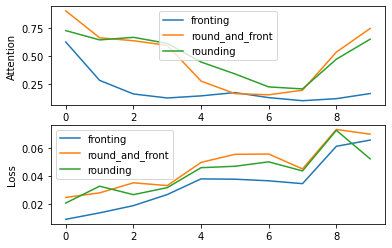

In [466]:
import matplotlib

df_anl = df_mle[['group', 'Time', "Loss", "Attention"]].groupby(['group', 'Time']).mean()

figure_outputs, (attn_plot, loss_plot) = plt.subplots(2)

for grp in np.unique(df_mle['group']):
    attn_plot.plot(df_anl['Attention'][grp], label=grp)
    attn_plot.set_ylabel('Attention')
    loss_plot.plot(df_anl['Loss'][grp], label=grp)
    loss_plot.set_ylabel('Loss')

attn_plot.legend()
loss_plot.legend()


Time
0    0.591872
1    0.256373
2    0.144084
3    0.112387
4    0.135668
5    0.180257
6    0.139177
7    0.096083
8    0.102605
9    0.128945
Name: Attention, dtype: float64


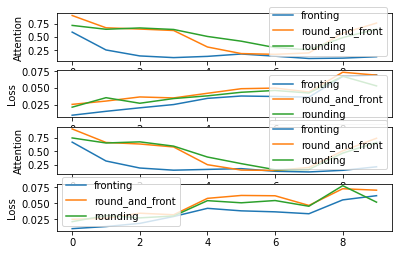

In [467]:
df_anl = df_mle[['group', 'Time', "V2", "Loss", "Attention"]].groupby(['group', "V2", 'Time']).mean()

print(df_anl['Attention']["fronting"]["H"])

figure_outputs, (attn_plot, loss_plot, attn_plot2, loss_plot2) = plt.subplots(4)

for grp in np.unique(df_mle['group']):
    attn_plot.plot(df_anl['Attention'][grp]["H"], label=grp)
    attn_plot.set_ylabel('Attention')
    loss_plot.plot(df_anl['Loss'][grp]["H"], label=grp)
    loss_plot.set_ylabel('Loss')
    attn_plot2.plot(df_anl['Attention'][grp]["L"], label=grp)
    attn_plot2.set_ylabel('Attention')
    loss_plot2.plot(df_anl['Loss'][grp]["L"], label=grp)
    loss_plot2.set_ylabel('Loss')

attn_plot.legend()
loss_plot.legend()
attn_plot2.legend()
loss_plot2.legend()

### Mixed linear effect models for each group

In [468]:
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison

''' From paper:
We used the identity of input V2 as 
    - either a high harmony trigger (/i, u/) 
      or a non-high non-trigger
    - and decoder timepoint as main factors, 
    - model as a random factor, 
    - and the attention value assigned to the encoder hidden state 
        associated with input V2 as the dependent variable.

This result suggests that the
decoder learns to pay more attention to a V2 at an
earlier timepoint when that V2 is a harmony trigger,
consistent with the representation of an anticipatory
(early-activating) gesture assumed by the Gestural
Harmony Model.
'''

# first fit a mixed linear model for each group

# divide the df into groups
rounding_df = df_mle[df_mle['group'] == 'rounding']
fronting_df = df_mle[df_mle['group'] == 'fronting']
two_way_df = df_mle[df_mle['group'] == 'round_and_front']
grouped_dfs = [rounding_df, fronting_df, two_way_df]

# perform an MLE on each group
linear_models = []
for grp in grouped_dfs:
  # model training 
  md = smf.mixedlm("Attention ~ Time + V2 + fronted + rounded + high", grp, groups=grp["model"])
  mdf = md.fit(reml=False)
  linear_models.append(mdf)
  print(f"{grp['group'].values[0]} results:")
  print(mdf.summary())

  # # tukey HSD
  mc = MultiComparison(grp['Attention'], groups=grp['V2'])
  print(mc.tukeyhsd().summary())

rounding results:
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Attention
No. Observations:  9600    Method:             ML       
No. Groups:        20      Scale:              0.0687   
Min. group size:   480     Log-Likelihood:     -808.1016
Max. group size:   480     Converged:          Yes      
Mean group size:   480.0                                
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.661    0.025  26.174 0.000  0.612  0.711
V2[T.L]      -0.056    0.005 -10.468 0.000 -0.066 -0.046
fronted[T.1]  0.051    0.005   9.528 0.000  0.040  0.061
rounded[T.1]  0.040    0.007   6.131 0.000  0.027  0.053
high[T.1]    -0.036    0.008  -4.755 0.000 -0.051 -0.021
Time         -0.033    0.001 -35.618 0.000 -0.035 -0.031
Group Var     0.012    0.014                            

Multiple Comparison of

/Users/hillel/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     H      L   0.0346   0.0 0.0256 0.0436   True
-------------------------------------------------
round_and_front results:
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Attention 
No. Observations: 9600    Method:             ML        
No. Groups:       20      Scale:              0.1101    
Min. group size:  480     Log-Likelihood:     -3070.2917
Max. group size:  480     Converged:          Yes       
Mean group size:  480.0                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     0.704    0.027  25.733 0.000  0.650  0.757
V2[T.L]      -0.031    0.007  -4.634 0.000 -0.045 -0.018
fronted[T.1]  0.013    0.007   1.890 0.059 -0.000

### Compare BIC

In [469]:
# compare model BIC
for m, grp in zip(linear_models, grouped_dfs):
    print(f"{grp['group'].values[0]} BIC: {m.bic}")

rounding BIC: 1689.5594313467918
fronting BIC: -4729.632246747624
round_and_front BIC: 6213.93949107669


### Compare attention across groups (one model)

In [470]:
# one mixed linear effects model
md = smf.mixedlm("Attention ~ Time + group * V2", df_mle, groups=df_mle["model"])
mdf = md.fit()
print(mdf.summary())

## tukey HSD
mc = MultiComparison(df_mle['Attention'], groups=df_mle['group'])
print(mc.tukeyhsd().summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Attention 
No. Observations:         28800         Method:                   REML      
No. Groups:               60            Scale:                    0.0719    
Min. group size:          480           Log-Likelihood:           -3116.8695
Max. group size:          480           Converged:                Yes       
Mean group size:          480.0                                             
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.343    0.024  14.597 0.000  0.297  0.389
group[T.round_and_front]          0.317    0.033   9.595 0.000  0.252  0.382
group[T.rounding]                 0.342    0.033  10.336 0.000  0.277  0.406
V2[T.L]            

### Compare loss across groups (ANOVA)

In [471]:
from statsmodels.formula.api import ols

lm = ols('Loss ~ C(group, Sum)', data=df_mle).fit()
anova = sm.stats.anova_lm(lm, typ=2)
print(anova)

                  sum_sq       df           F         PR(>F)
C(group, Sum)   0.792473      2.0  473.643046  4.076780e-203
Residual       24.090759  28797.0         NaN            NaN


## Visualize the hidden state

In [472]:
# construct a matrix of hidden states

# helper function
def get_hidden_states(training_data, word, model):
    input, target, model = get_trial(training_data, word, model)
    return model.get_hidden(input, target)

# get all the hidden states

LOAD_MODELS = True
NO_MODELS = 20
NO_EPOCHS = 200

# iterate through each analysis
df_all2, factors = None, None
for k, analysis in enumerate(analyses):
    # iterate over 20 different models
    for j in range(NO_MODELS):
        # train a new model
        if LOAD_MODELS:
            analysis_str = "_".join([s[0:2] for s in analysis])
            save_file = f"saved_models/gestnet_{analysis_str}_{j+1}_{NO_EPOCHS}.pt"
            model = Seq2Seq(load=save_file, articulators=analysis)
        else:
            model = Seq2Seq(training_data=data_stepwise, articulators=analysis)
            model.train_model(training_data=data_stepwise, n_epochs=NO_EPOCHS)
            model.save()

        model.eval()

        # get the attention values from the model
        df = get_hidden_states(data_stepwise, data['underlying'].values[0], model)
        factors = pd.DataFrame([data['underlying'].values[0], data['vowel'].values[0]])
        for i in range(1, data['underlying'].shape[0]):
            df = pd.concat(
                (df, get_values(data_stepwise, data['underlying'].values[i], model)),
                axis=0
            )
            factors = pd.concat(
                (factors, [data['underlying'].values[0], data['vowel'].values[0]]),
                axis=0
            )

        # reset the indexes
        df = df.reset_index().drop('index', axis=1)
        factors = factors.reset_index().drop('index', axis=1)

        print(end='\x1b[2K')
        print(f"{(j+1) + (k * NO_MODELS)}/{NO_MODELS * len(analyses)}")

ModuleAttributeError: 'Seq2Seq' object has no attribute 'get_hidden'

In [ ]:
# dimensionality reduction

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# first reduce to 40 dimensions
pca = PCA(n_components=40)
reduced = pca.fit_transform(df.to_numpy())

# reduce to 2 dimensions
tnse = TSNE(n_components=2, learning_rate='auto', init='random')
embedding = tnse.fit_transform(reduced)

# concatenate embeddings with factors
embeddings = pd.concat((embedding, factors), axis=1)

In [ ]:
df = df_all